In [1]:
# Spark init. / Data Path
from pyspark.sql import SparkSession
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")
review_path = "gs://" + bucket + "/amazon_reviews_2023/silver/reviews_combined_compact"
meta_path = "gs://" + bucket + "/amazon_reviews_2023/silver/meta_combined_compact"
print(review_path)
print(meta_path)

gs://qst843-project/amazon_reviews_2023/silver/reviews_combined_compact
gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact


In [2]:
# Load Cleaned Data (Review & Meta)
df_reviews = spark.read.option("recursiveFileLookup", "true").parquet(review_path)
df_meta = spark.read.option("recursiveFileLookup", "true").parquet(meta_path)

In [3]:
# Rename / Drop Duplicate Field Names ("title", "category_name")
df_reviews = df_reviews.withColumnRenamed("title", "review_title")
df_meta = df_meta.withColumnRenamed("title", "product_name")
df_meta = df_meta.drop("category_name")

In [4]:
# Check Review Data
df_reviews.printSchema()
df_reviews.show()

root
 |-- user_id: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_image: boolean (nullable = true)
 |-- category_name: string (nullable = true)



+--------------------+-----------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+
|             user_id|parent_asin|          timestamp|rating|        review_title|                text|helpful_vote|verified_purchase|review_image|       category_name|
+--------------------+-----------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+
|AGZPNP4EC4Z7CTHY2...| B07V34XSJ8|2021-05-30 08:51:53|     5|        Comfortable!|    These are great!|           0|             true|       false|Arts_Crafts_and_S...|
|AFOCCQXZYCTLGLQ4Y...| B0047BITNI|2015-03-10 18:23:14|     5|          Five Stars|          very nice.|           0|             true|       false|Arts_Crafts_and_S...|
|AE5XOXRPK5ZCDD2DC...| B08Z7CRNSC|2022-01-17 16:45:32|     5|        Very pleased|  Just what I wanted|           0|             true|       false|Arts_Cra

In [5]:
# Check Meta Data
df_meta.printSchema()
df_meta.show()

root
 |-- parent_asin: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- store: string (nullable = true)
 |-- product_image: boolean (nullable = true)
 |-- product_video: boolean (nullable = true)



+-----------+--------------------+-------------+----------+-----+--------------------+--------------------+--------------+-------------+-----+-------------+-------------+-------------+
|parent_asin|        product_name|main_category|categories|price|            features|         description|average_rating|rating_number|brand|        store|product_image|product_video|
+-----------+--------------------+-------------+----------+-----+--------------------+--------------------+--------------+-------------+-----+-------------+-------------+-------------+
| B01AB5SIXO|NuGene NuEye Eye ...|   All Beauty|        []| NULL|                  []|                  []|           5.0|            1| NULL|         NULL|         true|        false|
| B07DNP5SY9|18INCH #24 Ash Bl...|   All Beauty|        []| NULL|                  []|                  []|           1.0|            1| NULL|     benehair|         true|        false|
| B08F51HG1R|Headbands for Wom...|   All Beauty|        []| NULL|          

In [7]:
# Join Review & Meta Data into a Single df
df = df_reviews.join(
    df_meta,
    on="parent_asin",
    how="left"
)

In [8]:
# Check Joined Data
df.printSchema()
df.show()

root
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_image: boolean (nullable = true)
 |-- category_name: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- store: string (nullable = true)
 |-- produ

+-----------+--------------------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------+-------------+-----+--------------+-------------+-------------+
|parent_asin|             user_id|          timestamp|rating|        review_title|                text|helpful_vote|verified_purchase|review_image|       category_name|        product_name|       main_category|          categories| price|            features|         description|average_rating|rating_number|brand|         store|product_image|product_video|
+-----------+--------------------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--

In [9]:
df.select("category_name").distinct().show(truncate=False)

+---------------------------+
|category_name              |
+---------------------------+
|Patio_Lawn_and_Garden      |
|Cell_Phones_and_Accessories|
|Automotive                 |
|Arts_Crafts_and_Sewing     |
|Grocery_and_Gourmet_Food   |
|Baby_Products              |
|Office_Products            |
|Musical_Instruments        |
|Health_and_Personal_Care   |
|All_Beauty                 |
+---------------------------+



## EDA Part

### EDA 1.
#### Does verified purchase affect ratings?
According to the Amazon website (https://www.amazon.com/gp/help/customer/display.html?nodeId=G8UYX7LALQC8V9KA), \
**Verified Purchase** means that Amazon has confirmed the reviewer actually bought or used the product through their own Amazon account, or that the reviewer has an Amazon Credit Card associated with their account.

From this EDA section, we tried to find the correlation between *Verified Purchase* and *Review Rating*.
If *Verified Purchase* and *Review Rating* are **positively correlated**, we could develop strategies to increase the number of *Verified Purchases*.

In [10]:
from pyspark.sql import functions as F

# Boolean to Numeric (True=1, False=0)
df_corr = df.withColumn("verified_purchase", F.when(F.col("verified_purchase") == True, 1).otherwise(0))

# Compute Correlation Group by "category_name"
category_corr = (
    df_corr.groupBy("category_name")
    .agg(F.corr("verified_purchase", "rating").alias("correlation"))
    .orderBy(F.desc("correlation"))
)

category_corr.show(20, truncate=False)


+---------------------------+----------------------+
|category_name              |correlation           |
+---------------------------+----------------------+
|Baby_Products              |0.04945546563377559   |
|Grocery_and_Gourmet_Food   |0.04055285348296323   |
|Musical_Instruments        |0.03743306353613122   |
|Automotive                 |0.037106652631418185  |
|Office_Products            |0.03660729525966332   |
|Patio_Lawn_and_Garden      |0.02693815580948025   |
|Cell_Phones_and_Accessories|0.00910146141331315   |
|Arts_Crafts_and_Sewing     |0.008831825752796058  |
|Health_and_Personal_Care   |-0.0025580924708461738|
|All_Beauty                 |-0.02476111260203552  |
+---------------------------+----------------------+



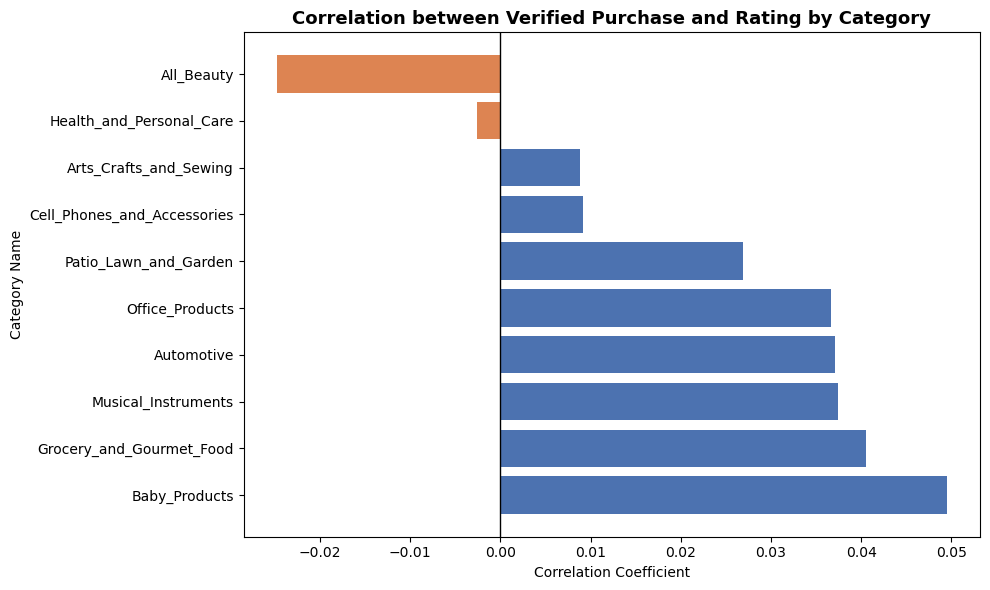

In [13]:
import matplotlib.pyplot as plt

# Visualize Correlations with Bar Graph
pdf_corr = category_corr.toPandas().dropna(subset=["correlation"])

plt.figure(figsize=(10, 6))
plt.barh(
    pdf_corr["category_name"],
    pdf_corr["correlation"],
    color=["#4C72B0" if c > 0 else "#DD8452" for c in pdf_corr["correlation"]]
)
plt.axvline(0, color="black", lw=1)
plt.title("Correlation between Verified Purchase and Rating by Category", fontsize=13, weight='bold')
plt.xlabel("Correlation Coefficient")
plt.ylabel("Category Name")
plt.tight_layout()
plt.show()


#### Insight)
We found that the correlation between *Verified Purchase* and *Review Rating* is **very weak**, \
but we found slight of correlation difference between "All_Beauty" and "Baby_Products" (Negative / Positive)

#### Verified Purchases Skewness
We found that there is very weak correlation between *Verified Purchase* and *Review Rating*. \
Although some categories showed differences in negative and positive correlations, we aimed to take a closer look at each category’s characteristics by examining how *Verified Purchase* and *Non-Verified Purchase* reviews are actually skewed.

By comparing *Verified Purchase* and *Non-Verified Purchase* reviews, we aim to identify which product categories show the highest and most significant skewness toward high ratings among verified purchases. \
For those categories, it would likely be advantageous to implement targeted strategies focused on increasing the proportion of Verified Purchases.

In [28]:
from pyspark.sql import functions as F
# Calculate skewness of ratings
def skew_by_category(df_in):
    base = (df_in
            .filter(F.col("rating").between(1, 5))
            .filter(F.col("category_name").isNotNull())
            .select("category_name", F.col("rating").cast("double").alias("x")))
    
    mom = (base.groupBy("category_name")
           .agg(F.count("x").alias("n"),
                F.sum("x").alias("s1"),
                F.sum(F.pow("x", 2)).alias("s2"),
                F.sum(F.pow("x", 3)).alias("s3")))
    
    res = (mom
        .withColumn("mu", F.col("s1")/F.col("n"))
        .withColumn("m2", (F.col("s2")/F.col("n")) - F.col("mu")**2)
        .withColumn("m3", (F.col("s3")/F.col("n")) - 3*F.col("mu")*(F.col("s2")/F.col("n")) + 2*F.col("mu")**3)
        .withColumn("g1", (F.sqrt(F.col("n")*(F.col("n")-1))/(F.col("n")-2)) * (F.col("m3")/F.col("m2")**1.5))
        .select(
            "category_name",
            F.col("n").alias("cnt"),
            F.col("mu").alias("mean_rating"),
            F.when((F.col("n") > 2) & (F.col("m2") > 0), -1*F.col("g1")).alias("skew")  # + = 4~5 쏠림
        ))
    return res

# Differentiate Verified vs. non-Verified
ver  = skew_by_category(df.filter(F.col("verified_purchase") == True)).alias("v")
non  = skew_by_category(df.filter(F.col("verified_purchase") == False)).alias("nv")

# Join verified and non-verified calculations
skew_compare = (ver.join(non, "category_name", "inner")
    .select(
        F.col("category_name"),
        F.col("v.cnt").alias("cnt_verified"),
        F.col("nv.cnt").alias("cnt_nonverified"),
        F.col("v.mean_rating").alias("mean_verified"),
        F.col("nv.mean_rating").alias("mean_nonverified"),
        F.col("v.skew").alias("skew_verified"),
        F.col("nv.skew").alias("skew_nonverified"),
    ))

skew_compare.show(20, truncate=False)

# Pandas for graph
pdf = skew_compare.toPandas()



+---------------------------+------------+---------------+------------------+------------------+------------------+------------------+
|category_name              |cnt_verified|cnt_nonverified|mean_verified     |mean_nonverified  |skew_verified     |skew_nonverified  |
+---------------------------+------------+---------------+------------------+------------------+------------------+------------------+
|All_Beauty                 |628456      |65796          |3.948922438484158 |4.0752173384400265|1.0690200099387248|1.2988042047572939|
|Patio_Lawn_and_Garden      |15362546    |955592         |4.059853230057049 |3.8915363460556387|1.251022897660583 |1.0193568513041915|
|Cell_Phones_and_Accessories|19501687    |1074696        |4.019075529209345 |3.9592610375399184|1.1791391444118455|1.104413832854662 |
|Automotive                 |18984235    |738978         |4.1939568278626975|3.9241790689303335|1.4980238556345273|1.0624002928018461|
|Musical_Instruments        |2749398     |234382       

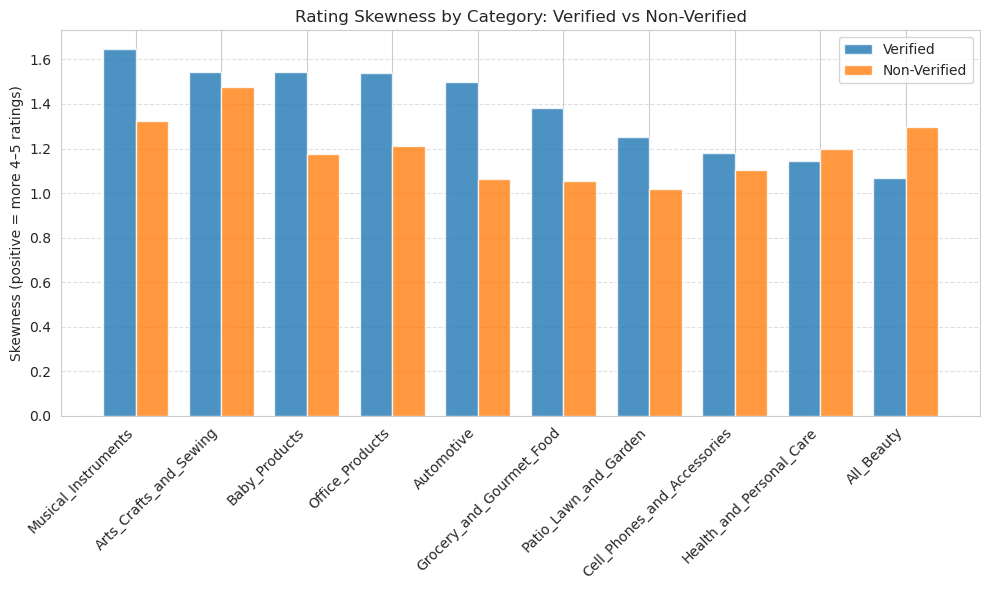

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# Compare (non)Verified purchase skewness
pdf = skew_compare.toPandas().sort_values("skew_verified", ascending=False).head(10)

x = np.arange(len(pdf))
w = 0.38
plt.figure(figsize=(10,6))
plt.bar(x - w/2, pdf["skew_verified"],  width=w, label="Verified",     alpha=0.8)
plt.bar(x + w/2, pdf["skew_nonverified"], width=w, label="Non-Verified", alpha=0.8)
plt.xticks(x, pdf["category_name"], rotation=45, ha="right")
plt.ylabel("Skewness (positive = more 4–5 ratings)")
plt.title("Rating Skewness by Category: Verified vs Non-Verified")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



#### Insight)
According to the EDA results, **Musical Instruments, Baby Products, Office Products, Automotive, and Grocery** categories showed noticeably higher skewness toward high ratings in *Verified Purchase* reviews compared to *Non-Verified Purchase* reviews. \
On the other hand, **All Beauty** products showed relatively lower skewness for *Verified Purchases*. \
Therefore, it is expected that implementing strategies to increase and encourage *Verified Purchases* in categories such as **Musical Instruments, Baby Products, Office Products, Automotive, and Grocery** would be advantageous.

### EDA 2
#### Helpful Votes and ratings
All Amazon users can vote on whether a review was helpful.\
This *helpful (review) vote* serves as an important indicator of how much people are influenced by, or empathize with, reviews that either compliment or criticize a product.\

We aim to examine whether these helpful votes are related with the overall product ratings.\
If we find that products receiving many helpful votes on critical (low-rated) reviews tend to have lower average ratings, it would strongly suggest potential issues with product or service quality that such products may require closer monitoring or review.\
Conversely, if our hypothesis turns out to be wrong and products with many helpful votes on critical reviews do not show any lower average ratings, it may imply that helpful votes have limited influence on perceived product quality or customer satisfaction.

In [18]:
from pyspark.sql import functions as F

# Sum / Calculate helpful votes when Rating=1, Rating=5
df_helpful = (
    df.groupBy("parent_asin")
      .agg(
          F.avg("rating").alias("avg_rating"),
          F.sum(F.when(F.col("rating") == 1, F.col("helpful_vote")).otherwise(0)).alias("helpful_sum_r1"),
          F.sum(F.when(F.col("rating") == 5, F.col("helpful_vote")).otherwise(0)).alias("helpful_sum_r5")
      )
      .withColumn("helpful_diff", F.col("helpful_sum_r5") - F.col("helpful_sum_r1"))
)



In [19]:
pdf_helpful = df_helpful.toPandas()

# Negative helpful_diff → skew to low ratings, Positive helpful_diff → skew to high ratings
pdf_helpful["trend_group"] = pd.cut(
    pdf_helpful["helpful_diff"],
    bins=[-float("inf"), -1, 0, 1, float("inf")],
    labels=["Mostly 1", "Balanced", "Slightly more on 5", "Mostly 5"]
)


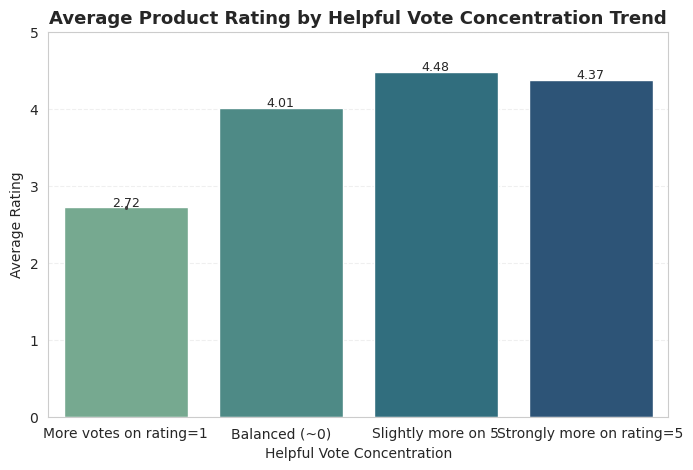

In [20]:
import seaborn as sns
# Show on Bar Graph
plt.figure(figsize=(8,5))
sns.barplot(
    data=pdf_helpful,
    x="trend_group",
    y="avg_rating",
    palette="crest",
    order=["More votes on rating=1", "Balanced (~0)", "Slightly more on 5", "Strongly more on rating=5"]
)

for i, v in enumerate(pdf_helpful.groupby("trend_group")["avg_rating"].mean()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)

plt.title("Average Product Rating by Helpful Vote Concentration", fontsize=13, weight='bold')
plt.xlabel("Helpful Vote Concentration")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


#### Insight)
According to the graph, we observed a clear decline in the average rating as the number of helpful votes on critical (1-star) reviews increased.\
This finding supports our hypothesis: when critical reviews accumulate a large number of helpful votes, it can be considered as a red flag indicating potential issues with the product’s quality or service, warranting further investigation and corrective action.

## Conclusion
Our exploratory analysis reveals several actionable insights into customer satisfaction and product performance on Amazon’s platform.

**1) Category-Level Insights and Strategic Positioning**
Amazon’s highest satisfaction levels occur in general, functional product categories such as Baby Products, Office Products, and Grocery & Gourmet Food. In contrast, more personal and preference-driven segments like Beauty or Health & Personal Care exhibit lower ratings. \
* **Business Action**: Amazon and sellers could prioritize personalization strategies—such as tailored recommendations, improved product imagery, and targeted reviews— especially for categories where subjective preference plays a greater role like Beauty or Health & Personal Care products.\
* **Limitation**: Ratings alone cannot fully capture specific reasons why certain product categories receive negative reviews.

**2) Price vs. Rating Relationship**
Across most price ranges, ratings cluster between 4 and 5 stars, indicating that cost is not a primary driver of satisfaction. However, very high-priced items (>$1,500) rarely receive extremely low ratings, possibly due to higher quality assurance or smaller, more selective buyer groups.\
* **Business Action**: Sellers should not assume that price increases improve satisfaction; thus, additional price-related strategy may not be needed.\
* **Limitation**: The analysis does not account for brand reputation or product preference on certain brands, which may strongly affect rating behavior regardless prices.

**3) Content Quality and Product Presentation**
Products featuring videos or images consistently receive higher ratings, and shorter or medium-length descriptions perform slightly better than long, text-heavy ones. This suggests that clear and visually supportive content enhances trust and perceived product quality.\
* **Business Action**: Optimize listings by incorporating concise descriptions and rich media assets (images, videos). Consider A/B testing content length to find the engagement optimization.\
* **Limitation**: Content quality was inferred from metadata rather than directly measured (e.g., actual image/video clarity or linguistic quality may not be considered).

**4) Helpfulness Concentration and Customer Trust Signals**
When 1-star reviews accumulate many “helpful” votes, average product ratings drop significantly (as low as 2.72). This pattern indicates that customers collectively signal quality or service issues through engagement behavior.\
* **Business Action**: Monitor helpful-vote concentration as an early-warning indicator for emerging product problems or reputation risks. Integrate this into quality-control dashboards for proactive intervention.\
* **Limitation**: Rating might not completely represent the quality of products or services.

### Next Steps

**Modeling**: Develop a regression or classification model linking review text, multimedia presence, and helpfulness metrics to predict future satisfaction scores.

**Data Enrichment**: Incorporate temporal variables (review age, product lifecycle stage) and sentiment-analysis results from review text to refine causal understanding.

**Monitoring System**: Build automated alerts for anomalies in helpful-vote concentration or sudden rating drops to support real-time decision-making.